# Antibiotics and PCA

Regenerate the figure on antibiotic usage and PCA but using our reduced dimensionality vectors

In [1]:
import os
import sys
from socket import gethostname

# this is for ffmpeg
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/miniconda3/envs/bioinformatics/bin')

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

In [2]:
encoder_models = 'cluster_gbrfs'
# encoder_models = 'cluster_gbrfs_all'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

In [3]:
intcol = 'Sum of antibiotics'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

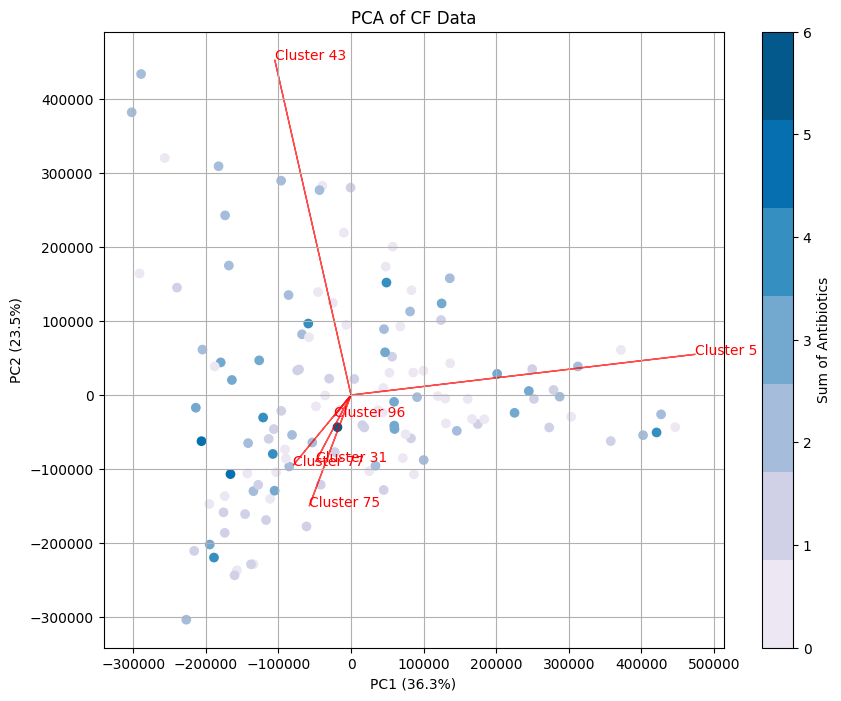

In [4]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

cpalette = 'PuBu'
# Plot PCA scatter, color by metadata
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=metadata['Sum of antibiotics'], cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
plt.colorbar(scatter, label='Sum of Antibiotics')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA of CF Data')

# Plot loadings (top contributing variables)
topN = 6
loadings = pca.components_.T  # shape: (150 variables, 2 PCs)
loading_magnitude = np.sum(loadings**2, axis=1)
top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables

sep = 500000
for i in top_indices:
    plt.arrow(0, 0, loadings[i, 0]*sep, loadings[i, 1]*sep, color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*sep, loadings[i, 1]*sep, X.columns[i], color='r', fontsize=10)

plt.grid(True)
plt.show()

In [5]:
list(cluster_assignments[cluster_assignments['Cluster'] == 75]['Feature'])

['Listeria Pathogenicity Island LIPI-1 extended',
 'Methylglyoxal resistance in Bacillus subtilis',
 'Desulfotomaculaceae',
 'p-Aminobenzoyl-Glutamate Utilization',
 'Biofilm formation in Staphylococcus',
 'Adhesins in Staphylococcus',
 'Formaldehyde assimilation: Ribulose monophosphate pathway',
 'Fosfomycin resistance',
 'Staphylococcaceae',
 'Pore-forming cytolytic toxins',
 'Alpha-acetolactate operon',
 'Actinospicaceae',
 "Biosynthesis of 4,4'-diapolycopene dialdehyde",
 'Methylacidiphilaceae',
 'Toxins',
 'Desulfococcaceae',
 'Siderophore Anthrachelin',
 'Siderophore Staphylobactin',
 'Teicoplanin resistance in Staphylococci',
 'Bacillithiol synthesis']

In [6]:
cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence

,Tokens,Virulence Factors,Intersection,Union,Jaccard Distance,Frac cluster virulence,Enrichment Score
Cluster,,,,,,,
Cluster 1,4,867,0,871,0.000000,0.00,-1.000000
Cluster 2,6,867,0,873,0.000000,0.00,-1.000000
Cluster 3,6,867,0,873,0.000000,0.00,-1.000000
Cluster 4,7,867,0,874,0.000000,0.00,-1.000000
Cluster 5,8,867,0,874,0.000000,0.00,-1.000000
...,...,...,...,...,...,...,...
Cluster 146,47,867,0,914,0.000000,0.00,-1.000000
Cluster 147,25,867,1,891,0.001122,0.04,-0.891857
Cluster 148,8,867,0,875,0.000000,0.00,-1.000000


In [7]:
cluster_virulence.sort_values(by='Jaccard Distance', ascending=False)

,Tokens,Virulence Factors,Intersection,Union,Jaccard Distance,Frac cluster virulence,Enrichment Score
Cluster,,,,,,,
Cluster 131,19,867,3,883,0.003398,0.157895,-0.573120
Cluster 31,40,867,3,904,0.003319,0.075000,-0.797232
Cluster 117,8,867,2,873,0.002291,0.250000,-0.324106
Cluster 145,38,867,2,903,0.002215,0.052632,-0.857707
Cluster 74,2,867,1,868,0.001152,0.500000,0.351788
...,...,...,...,...,...,...,...
Cluster 47,4,867,0,871,0.000000,0.000000,-1.000000
Cluster 46,4,867,0,871,0.000000,0.000000,-1.000000
Cluster 45,4,867,0,871,0.000000,0.000000,-1.000000


In [8]:
cluster_virulence['Jaccard Distance'].max()

0.0033975084937712

# Plot the grid using griddata interpolation

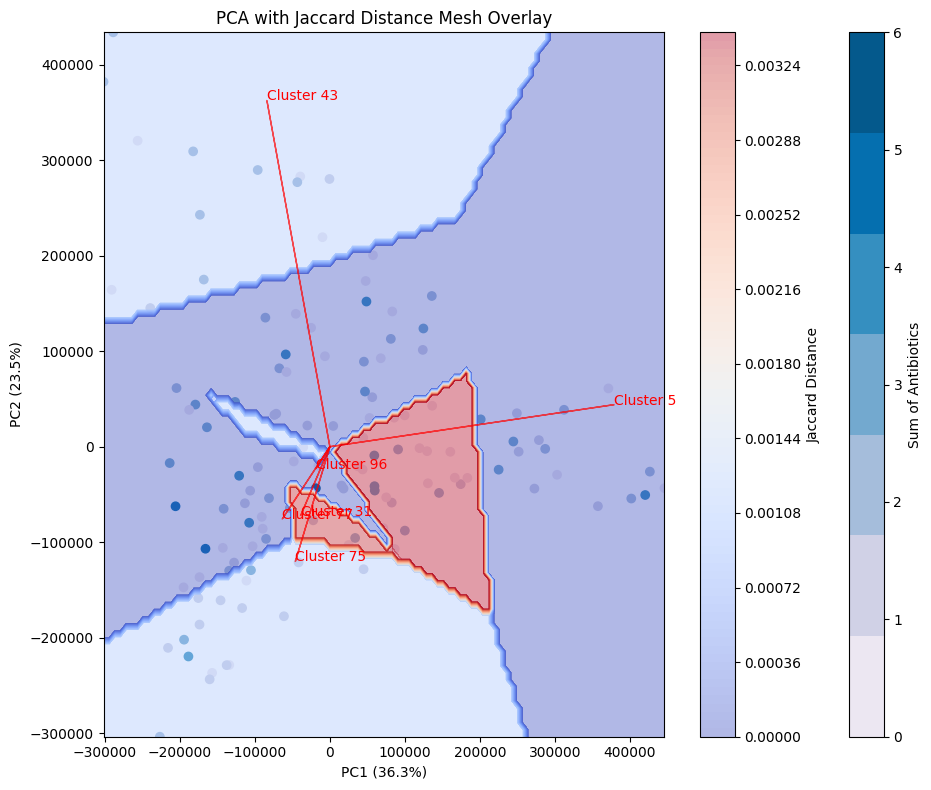

In [9]:
loading_weight = round(max(pca_result[:, 0]), -5) # this rounds to the nearest 100,000 and could be weird for another value. Probably needs generatlising
loadings = pca.components_.T
x_load, y_load = loadings[:, 0]*loading_weight, loadings[:, 1]*loading_weight

# Get enrichment scores for each variable
es = 'Jaccard Distance'
enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]

# 3. Create grid
#grid_x, grid_y = np.mgrid[min(x_load)-1:max(x_load)+1:100j, min(y_load)-1:max(y_load)+1:100j]
grid_x, grid_y = np.mgrid[min(pca_result[:, 0])-1:max(pca_result[:, 0])+1:100j, min(pca_result[:, 1])-1:max(pca_result[:, 1])+1:100j]

# 4. Interpolate enrichment scores over grid
grid_z = griddata((x_load, y_load), enrichment_scores, (grid_x, grid_y), method='nearest', rescale=True) # can be linear, nearest, or cubic

# 5. Plot PCA scatter
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=metadata['Sum of antibiotics'], cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
plt.colorbar(scatter, label='Sum of Antibiotics')

# 6. Overlay mesh
mesh = plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='coolwarm', alpha=0.4)
cbar = plt.colorbar(mesh)
cbar.set_label(es)

# 7. Plot loadings arrows
for i in top_indices:
    plt.arrow(0, 0, loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, X.columns[i], color='r', fontsize=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'PCA with {es} Mesh Overlay')
plt.grid(False)
plt.tight_layout()
plt.show()

In [10]:
grid_x.min()

-301996.85562038823

In [11]:
max(pca_result[:, 0])

446462.40990846005

In [12]:
max(pca_result[:, 1])

433725.8978519633

# Plot the grid using RBF interpolation

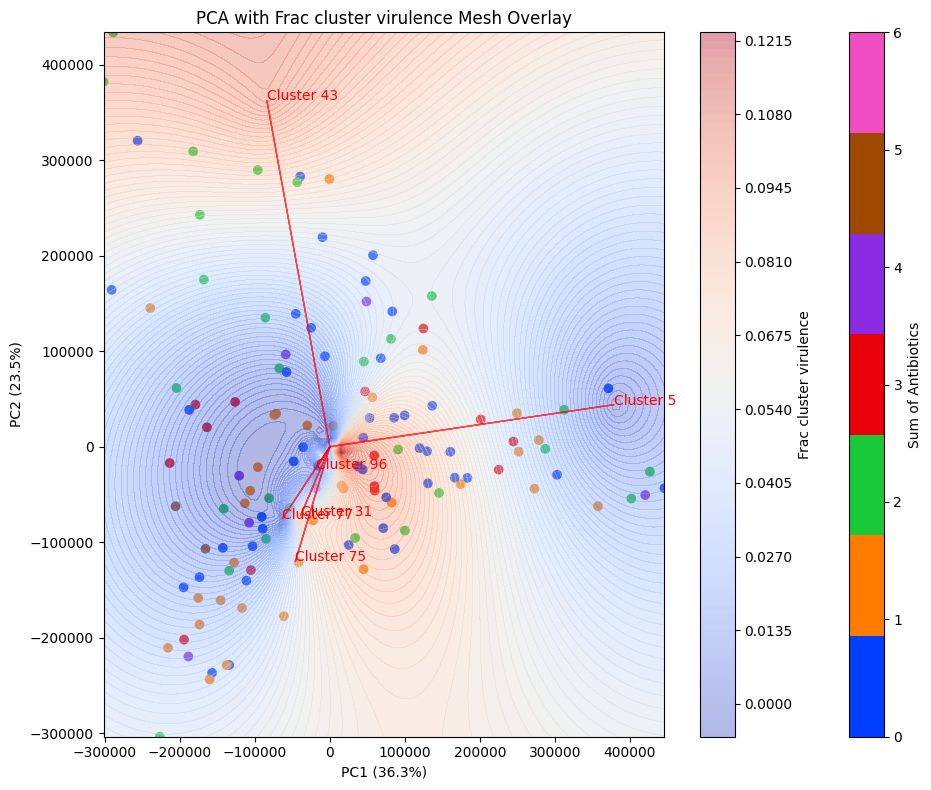

In [13]:
loading_weight = round(max(pca_result[:, 0]), -5) # this rounds to the nearest 100,000 and could be weird for another value. Probably needs generatlising
loadings = pca.components_.T
x_load, y_load = loadings[:, 0]*loading_weight, loadings[:, 1]*loading_weight

# Get enrichment scores for each variable
es = 'Frac cluster virulence' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence'
enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]

# 3. Create grid
#grid_x, grid_y = np.mgrid[min(x_load)-1:max(x_load)+1:100j, min(y_load)-1:max(y_load)+1:100j]
grid_x, grid_y = np.mgrid[min(pca_result[:, 0])-1:max(pca_result[:, 0])+1:100j, min(pca_result[:, 1])-1:max(pca_result[:, 1])+1:100j]

# 4. RBF interpolation
rbf = Rbf(x_load, y_load, enrichment_scores, function='linear')
grid_z = rbf(grid_x, grid_y)


# 5. Plot PCA scatter
cpalette = 'bright'
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=metadata['Sum of antibiotics'], cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
plt.colorbar(scatter, label='Sum of Antibiotics')

# 6. Overlay mesh
mesh = plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='coolwarm', alpha=0.4)
cbar = plt.colorbar(mesh)
cbar.set_label(es)

# 7. Plot loadings arrows
for i in top_indices:
    plt.arrow(0, 0, loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, X.columns[i], color='r', fontsize=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'PCA with {es} Mesh Overlay')
plt.grid(False)
plt.tight_layout()
plt.show()

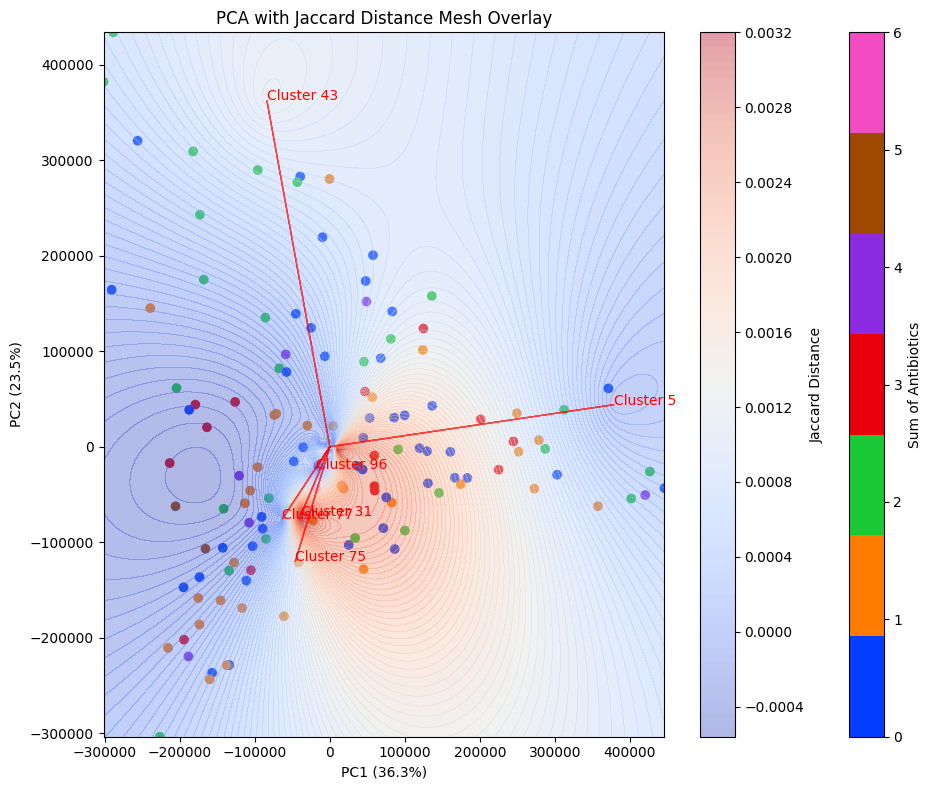

In [14]:
loading_weight = round(max(pca_result[:, 0]), -5) # this rounds to the nearest 100,000 and could be weird for another value. Probably needs generatlising
loadings = pca.components_.T
x_load, y_load = loadings[:, 0]*loading_weight, loadings[:, 1]*loading_weight

# Get enrichment scores for each variable
es = 'Jaccard Distance' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence'
enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]


# 3. Prepare points and values for interpolation
points = np.column_stack((x_load, y_load))
values = np.array(enrichment_scores)

# 4. Create grid
grid_x, grid_y = np.mgrid[min(pca_result[:, 0])-1:max(pca_result[:, 0])+1:200j, min(pca_result[:, 1])-1:max(pca_result[:, 1])+1:200j]
grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

# 5. RBFInterpolator (supports different kernels like 'linear', 'multiquadric')
rbf_interp = RBFInterpolator(points, values, kernel='linear')
grid_z = rbf_interp(grid_points).reshape(grid_x.shape)

# 5. Plot PCA scatter
cpalette = 'bright'
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=metadata['Sum of antibiotics'], cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
plt.colorbar(scatter, label='Sum of Antibiotics')

# 6. Overlay mesh
mesh = plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='coolwarm', alpha=0.4)
cbar = plt.colorbar(mesh)
cbar.set_label(es)

# 7. Plot loadings arrows
for i in top_indices:
    plt.arrow(0, 0, loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, X.columns[i], color='r', fontsize=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'PCA with {es} Mesh Overlay')
plt.grid(False)
plt.tight_layout()
plt.show()

# The 3D version!

In [15]:
# 3D PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

# Prepare loadings and enrichment
loading_weight_X = round(max(pca_result[:, 0]), -5) 
loading_weight_Y = round(max(pca_result[:, 1]), -5) 
loading_weight_Z = round(max(pca_result[:, 2]), -5) 
loadings = pca.components_.T  # shape: (n_features, 3)
scaling_factor = 5000
x_load, y_load, z_load = loadings[:, 0]*loading_weight_X, loadings[:, 1]*loading_weight_Y, loadings[:, 2]*loading_weight_Z

topN = 6
loading_magnitude = np.sum(loadings**2, axis=1)
top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables


# Get enrichment scores for each variable
es = 'Enrichment Score' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence'
enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]
colors = plt.cm.coolwarm((np.array(enrichment_scores) + 1) / 2)  # Normalize -1 to 1

# 3. RBF interpolation
points = np.column_stack((x_load, y_load, z_load))
values = np.array(enrichment_scores)
rbf = RBFInterpolator(points, values, kernel='linear')

# 4. 3D Grid
# x_range = np.linspace(x_load.min()-2, x_load.max()+2, 30)
# y_range = np.linspace(y_load.min()-2, y_load.max()+2, 30)
# z_range = np.linspace(z_load.min()-2, z_load.max()+2, 30)

x_range = np.linspace(min(pca_result[:,0])-2, max(pca_result[:,0])+2, 30)
y_range = np.linspace(min(pca_result[:,1])-2, max(pca_result[:,1])+2, 30)
z_range = np.linspace(min(pca_result[:,2])-2, max(pca_result[:,2])+2, 30)


xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
grid_points = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
grid_vals = rbf(grid_points)


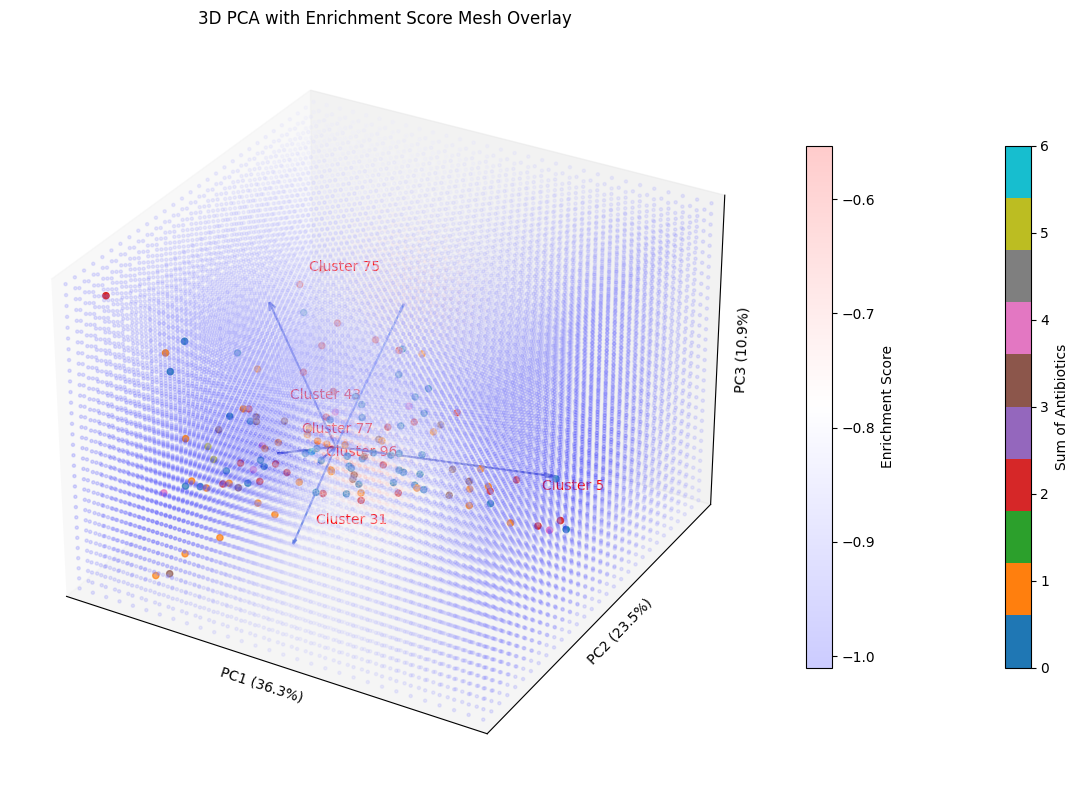

In [34]:
# 5. Plot enrichment as colored scatter mesh
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Enrichment mesh
sc_mesh = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], 
                     c=grid_vals, cmap='bwr', alpha=0.2, s=5)

# Sample points
sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                        c=metadata['Sum of antibiotics'], cmap='tab10', label='Samples')


# Loadings arrows
for i in top_indices:
    ax.quiver(0, 0, 0, 
              x_load[i], y_load[i], z_load[i], 
              color=colors[i], alpha=0.8, arrow_length_ratio=0.05)
    ax.text(x_load[i], y_load[1], z_load[i], X.columns[i], color='r', fontsize=10)

# Axes labels
ax.xaxis.labelpad = -10  # default ~10, so reduce to move closer
ax.yaxis.labelpad = -10
ax.zaxis.labelpad = -10
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title(f'3D PCA with {es} Mesh Overlay')

# adjust the ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlim(min(pca_result[:,0])-2, max(pca_result[:,0])+2)
ax.set_ylim(min(pca_result[:,1])-2, max(pca_result[:,1])+2)
ax.set_zlim(min(pca_result[:,2])-2, max(pca_result[:,2])+2)


# Colorbar

cb2 = fig.colorbar(sc_samples, label='Sum of Antibiotics', shrink=0.6, aspect=20)
cb = fig.colorbar(sc_mesh, shrink=0.6, aspect=20)
cb.set_label(es)
plt.grid(False)
plt.tight_layout()
plt.show()

# Lets make an animation

In [18]:
# Rotate function
def rotate(angle):
    ax.view_init(elev=30, azim=angle)

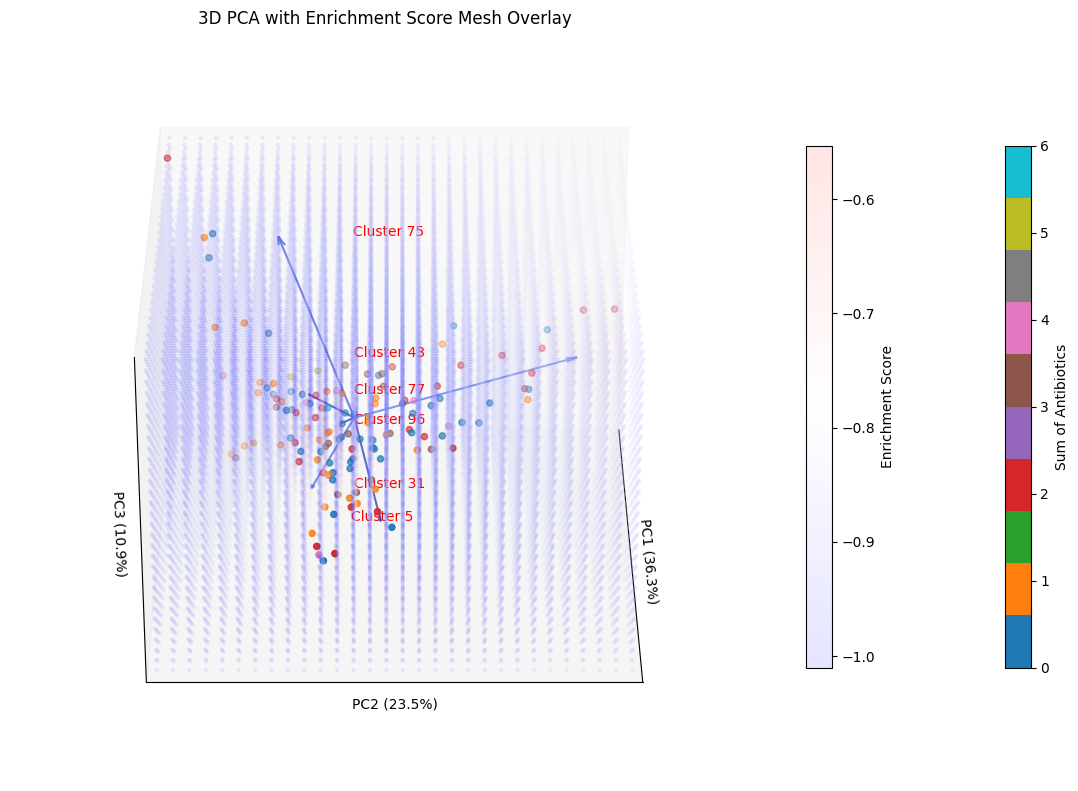

In [35]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Enrichment mesh
sc_mesh = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], 
                     c=grid_vals, cmap='bwr', alpha=0.1, s=5)

# Sample points
sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                        c=metadata['Sum of antibiotics'], cmap='tab10', label='Samples')


# Loadings arrows
for i in top_indices:
    ax.quiver(0, 0, 0, 
              x_load[i], y_load[i], z_load[i], 
              color=colors[i], alpha=0.8, arrow_length_ratio=0.05)
    ax.text(x_load[i], y_load[1], z_load[i], X.columns[i], color='r', fontsize=10)

# Axes labels
ax.xaxis.labelpad = -10  # default ~10, so reduce to move closer
ax.yaxis.labelpad = -10
ax.zaxis.labelpad = -10
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title(f'3D PCA with {es} Mesh Overlay')

# adjust the ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlim(min(pca_result[:,0])-2, max(pca_result[:,0])+2)
ax.set_ylim(min(pca_result[:,1])-2, max(pca_result[:,1])+2)
ax.set_zlim(min(pca_result[:,2])-2, max(pca_result[:,2])+2)

# Colorbar

cb2 = fig.colorbar(sc_samples, label='Sum of Antibiotics', shrink=0.6, aspect=20)
cb = fig.colorbar(sc_mesh, shrink=0.6, aspect=20)
cb.set_label(es)
plt.grid(False)
plt.tight_layout()
# Create animation
rot_animation = animation.FuncAnimation(fig, rotate, frames=range(0, 360, 2), interval=50)

# Save as mp4 (requires ffmpeg) or gif
rot_animation.save("img/pca_rotation.mp4", dpi=200, bitrate=1800)


In [31]:
values

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -0.79723183, -0.93712615, -1.        , -0.7542204 , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -0.66205306, -0.66205306, -0.72964245, -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -0.54940408, -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

In [20]:
!ffmpeg --version

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-18)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

In [32]:
X.columns

Index(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5',
       'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10',
       ...
       'Cluster 141', 'Cluster 142', 'Cluster 143', 'Cluster 144',
       'Cluster 145', 'Cluster 146', 'Cluster 147', 'Cluster 148',
       'Cluster 149', 'Cluster 150'],
      dtype='object', length=150)

In [33]:
col = 'Cluster 5'
cluster_virulence.loc[col, es]

-1.0